<a href="https://colab.research.google.com/github/RodrigoAgronomia/workshop_esalq/blob/master/python/12_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.2 Regression

In [0]:
%%capture
!pip install livelossplot
%cd /content
!git clone --depth 1 https://github.com/RodrigoAgronomia/workshop_esalq.git
%cd /content/workshop_esalq
!git pull
%cd /content/workshop_esalq/python

In [0]:
# Importação das bibliotecas necessárias para fazer o código funcionar - Caso apresente algum erro instalar a respectiva biblioteca
import os
import cv2
import time
import json
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from livelossplot import PlotLosses

In [3]:
# Verifica se o CUDA está presente no respectivo computador. Caso sim atribui ao devide. Caso não atribui o cpu, apresentando uma mensagem ao usuário
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [0]:
class CNNModel(torch.nn.Module):
    def __init__(self, n_output):
        super(CNNModel, self).__init__()
        
        # Convolution 0
        self.cnn0 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn0 = torch.nn.BatchNorm2d(32)
        self.mxp0 = torch.nn.MaxPool2d(2)
        self.relu0 = torch.nn.ReLU()
        
        # Convolution 1
        self.cnn1 = torch.nn.Conv2d(in_channels=32, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(20)
        self.mxp1 = torch.nn.MaxPool2d(2)
        self.relu1 = torch.nn.ReLU()
        
        # Convolution 2
        self.cnn2 = torch.nn.Conv2d(in_channels=20, out_channels=12, kernel_size=7, stride=1, padding=3)
        self.bn2 = torch.nn.BatchNorm2d(12)
        self.mxp2 = torch.nn.MaxPool2d(2)
        self.relu2 = torch.nn.ReLU()
        
        # Convolution 3
        self.cnn3 = torch.nn.Conv2d(in_channels=12, out_channels=8, kernel_size=9, stride=1, padding=4)
        self.bn3 = torch.nn.BatchNorm2d(8)
        self.mxp3 = torch.nn.MaxPool2d(2)
        self.relu3 = torch.nn.ReLU()
        
        
        self.prep = torch.nn.AdaptiveMaxPool2d(2)
        self.pred = torch.nn.Linear(32, n_output)

        
    def forward(self, x):
        # Convolution 1
        out = self.relu0(self.mxp0(self.bn0(self.cnn0(x))))
        out = self.relu1(self.mxp1(self.bn1(self.cnn1(out))))
        out = self.relu2(self.mxp2(self.bn2(self.cnn2(out))))
        out = self.relu3(self.mxp3(self.bn3(self.cnn3(out))))
        out = self.prep(out).view(out.shape[0], -1)
        out = self.pred(out) 
        return (out)

In [0]:
def prep_image(image):
    image = np.moveaxis(image, 2, 0)
    image = image.astype('float')
    image -= 128
    image /= 35
    return(image)
    
    
# Classe para preparo do dataset de treinamento e validação
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, im_dir, imList, labels):
        data = []
        #Prepara as imagens no formato numpy para poder ser lida pelo modelo
        for idx in range(len(imList)):
            image_name = imList[idx]
            image = cv2.imread(os.path.join(im_dir, image_name))
            image = prep_image(image)


            image = torch.from_numpy(image)
            label = torch.from_numpy(labels[[idx]])
            data.append([image, label])
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image, label = self.data[idx]
        images = Variable(image).to(device, dtype=torch.float)
        label = Variable(label).to(device, dtype=torch.float)
        
        return (images, label) #Retorna a imagem com sua respectiva máscara

In [0]:
# Diretório das imagens
im_dir = '../data/class'

imgs = sorted(os.listdir(im_dir))
imgs = [i for i in imgs if not i.endswith('msk.png')]
imgs = np.array(imgs)
# Seleciona aleatoriamente as imagens de treinamento e validação
im_train = np.arange(len(imgs))
im_val = np.random.choice(im_train, 30, replace=False)
im_train = np.setdiff1d(im_train,im_val)

cov = np.genfromtxt('../data/cov.csv', delimiter= ',', dtype='str')
cov = cov[:,1].astype('float')

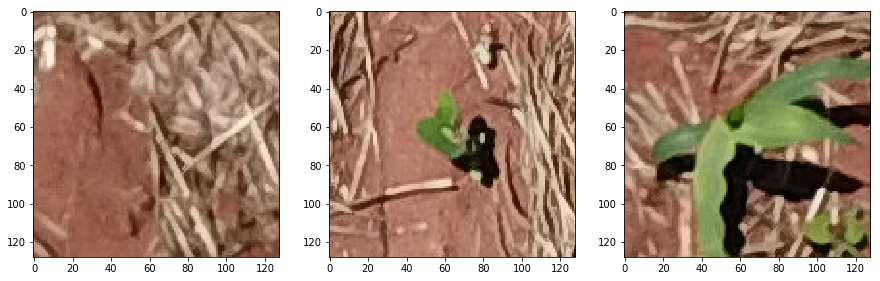

In [7]:
# Plota algumas das imagens dentro da pasta utilizada pelo modelo
plt.figure(figsize = (15,9))

im0 = cv2.imread(os.path.join(im_dir, imgs[50]))
im1 = cv2.imread(os.path.join(im_dir, imgs[150]))
im2 = cv2.imread(os.path.join(im_dir, imgs[250]))

ims = [im0, im1, im2]
for i in range(len(ims)):
        plt.figure(1)
        plt.subplot(1, 3, i+1)
        plt.imshow(ims[i][:,:,[2,1,0]])


In [0]:
train_dataset =  MyDataset(im_dir, imgs[im_train], cov[im_train]) #Seleciona as respectivas imagens de treinamento
val_dataset =  MyDataset(im_dir, imgs[im_val], cov[im_val]) #Seleciona as respectivas imagens de validação

In [0]:
# Batch_size (tamanho de lote) - número de exemplos de treinamento usados em uma iteração
# Carrega o dataset de treinamento
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=10,
                          shuffle=True,
                          num_workers=0
                         )

# Carrega o dataset de validação
val_loader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=10,
                          shuffle=False,
                          num_workers=0
                         )

In [0]:
n_output = 1 # Numero de outputs do modelo 
model = CNNModel(n_output)
model = model.to(device)
liveloss = PlotLosses()

In [11]:
# Apresenta um resumo das informações carregadas até o momento
# Input_size(numero de classes, tamanho da imagem - Resolução)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 20, 64, 64]          16,020
       BatchNorm2d-6           [-1, 20, 64, 64]              40
         MaxPool2d-7           [-1, 20, 32, 32]               0
              ReLU-8           [-1, 20, 32, 32]               0
            Conv2d-9           [-1, 12, 32, 32]          11,772
      BatchNorm2d-10           [-1, 12, 32, 32]              24
        MaxPool2d-11           [-1, 12, 16, 16]               0
             ReLU-12           [-1, 12, 16, 16]               0
           Conv2d-13            [-1, 8, 16, 16]           7,784
      BatchNorm2d-14            [-1, 8,

In [0]:
criterion = torch.nn.MSELoss()
learning_rate = 1e-3 #Taxa de aprendizado
optimizer = torch.optim.Adam(model.parameters(), learning_rate, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)

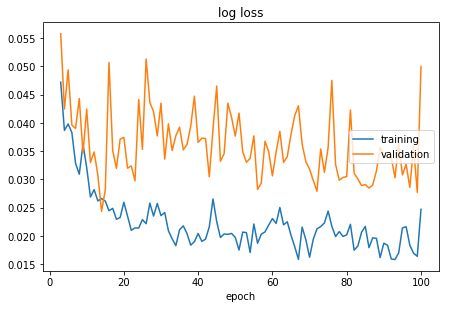

log loss:
training   (min:    0.016, max:    0.144, cur:    0.025)
validation (min:    0.024, max:    0.092, cur:    0.050)
[99] loss: 0.001 time:0.28


In [13]:
min_loss = 1
num_epochs = 100 # Define o número de épocas para realizar o treinamento 
for epoch in range(num_epochs):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        outputs = model(images)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, labels)

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (images, labels) in enumerate(val_loader):
        with torch.no_grad():
          # Obtem o output
          outputs = model(images)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, labels)

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        model_file_name = '../data/models/model_reg.pth'
        torch.save(model.state_dict(), model_file_name)

    liveloss.update({
        'log loss': np.sqrt(epoch_loss),
        'val_log loss': np.sqrt(val_loss)
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d] loss: %.3f time:%.2f' % (epoch, epoch_loss, time_taken))

In [14]:
# Cria um novo modelo
n_output = 1
model = CNNModel(n_output)
model = model.to(device)

# Carrega os pesos de um modelo salvo
model.load_state_dict(torch.load('../data/models/model_reg.pth', map_location=device))

#Apresenta uma mensagem caso esteja tudo certo com o modelo
print('Modelo OK')

Modelo OK


In [15]:
# Inicia o tempo para contagem
start_time = time.time()

# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
obs = []
preds = []
for i, (images, labels) in enumerate(train_loader):
    obs.append(labels.cpu().data.numpy())
    with torch.no_grad():
        pred = model(images)
    preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs)
preds = np.concatenate(preds)

# Faz a diferença para calcular o tempo           
time_taken = time.time() - start_time
# Apresenta o valor do tempo
print('time:%.2f' % (time_taken))


time:0.14


0.893


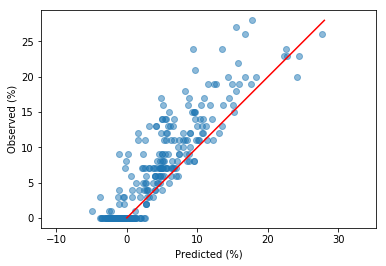

In [16]:
x = 100 * preds.reshape(-1)
y = 100 * obs.reshape(-1)

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, alpha=0.5)
plt.xlabel('Predicted (%)')
plt.ylabel('Observed (%)')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3))
plt.show()


In [17]:
# Inicia o tempo para contagem
start_time = time.time()

# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
obs = []
preds = []
for i, (images, labels) in enumerate(val_loader):
    obs.append(labels.cpu().data.numpy())
    with torch.no_grad():
        pred = model(images)
    preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs)
preds = np.concatenate(preds)

# Faz a diferença para calcular o tempo           
time_taken = time.time() - start_time
# Apresenta o valor do tempo
print('time:%.2f' % (time_taken))


time:0.02


0.764


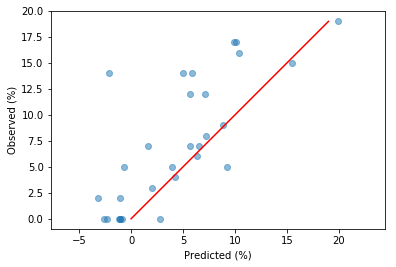

In [18]:
x = 100 * preds.reshape(-1)
y = 100 * obs.reshape(-1)

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, alpha=0.5)
plt.xlabel('Predicted (%)')
plt.ylabel('Observed (%)')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3))
plt.show()